In [1]:
### This file contains the solution of advanced_lane_finding project

### import some useful packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [2]:
### Camera Calibration 
### By following the steps and code provided in the class

# images in the folder
images=glob.glob('camera_cal/calibration*.jpg')

# array to store object points and images points from all the images
objpoints=[] #3D points in real world image
imgpoints=[] #2D points in image 

# prepare object points
nx = 9 #the number of inside corners in x
ny = 6 #the number of inside corners in y

# prepare object points 
objp = np.zeros((ny*nx,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


# Make a list of calibration images
for image in images:
    img = mpimg.imread(image)
    #plt.figure()
    #plt.imshow(img)
    
 
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #plt.figure()
    #plt.imshow(gray)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, draw corners
    if ret == True:
        
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        #cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)



In [3]:
# a function that takes an image, object points, and image points to perform the camera calibration, image distortion correction and 
# and to return the related parameters
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


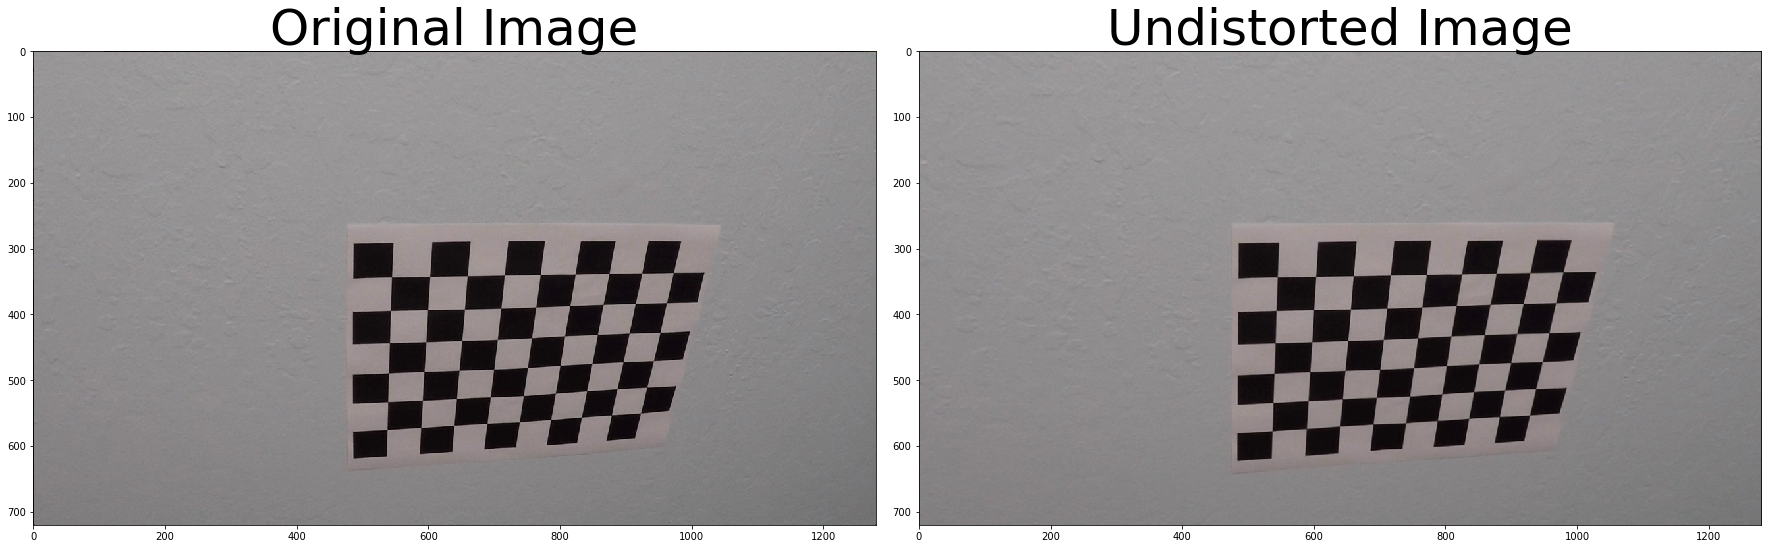

In [4]:
# choose a test image in the calibration images folder
calibration_img= cv2.imread('camera_cal/calibration10.jpg')

# undistort the test image
undistorted_calibration_img = cv2.undistort(calibration_img, mtx, dist, None, mtx)

# plot the test image and the distorted test image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(calibration_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_calibration_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# save the test results
plt.savefig('output_images/calibration10_calibration.jpg')

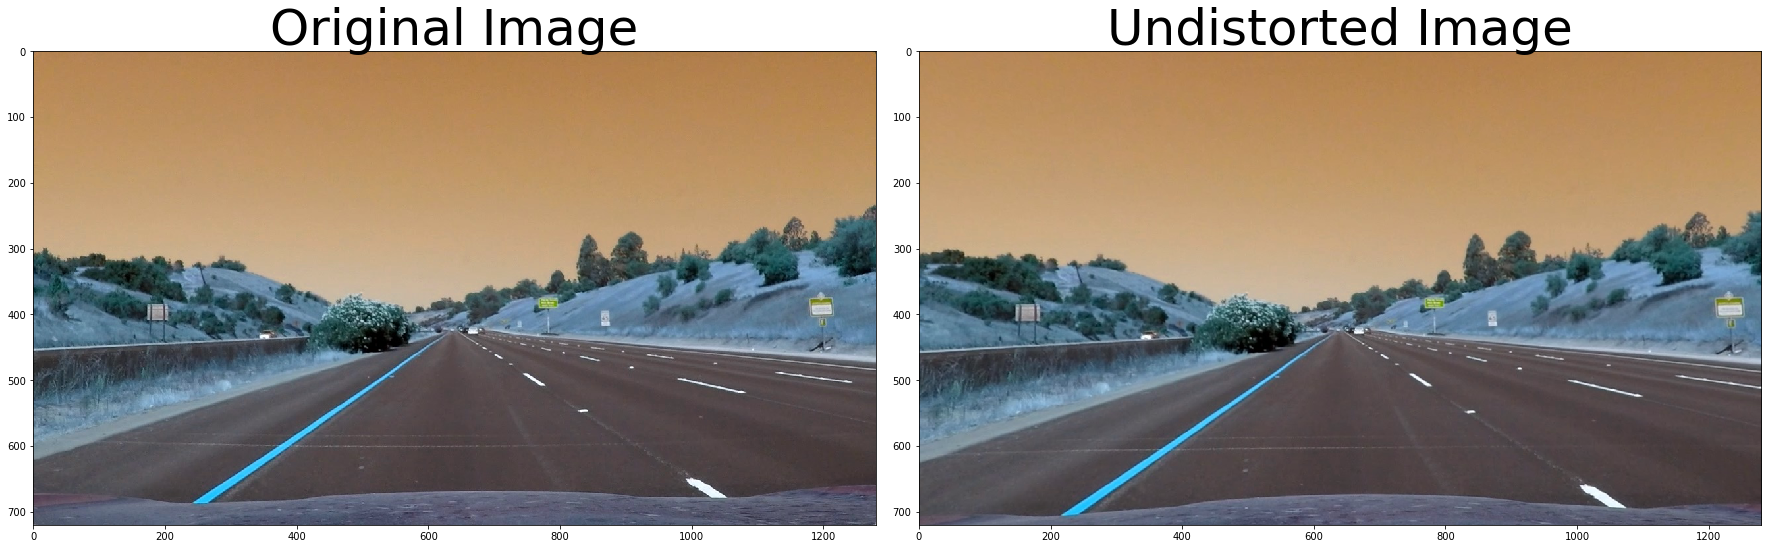

In [5]:
# choose a test image in the calibration images folder
test_img= cv2.imread('test_images/straight_lines1.jpg')

# undistort the test image
undistorted_test_img = cv2.undistort(test_img, mtx, dist, None, mtx)

#plt.figure()
#plt.imshow(undistorted_test_img)
#plt.savefig('output_images/straight_lines1_calibration_for_binary.jpg')

# plot the test image and the distorted test image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_test_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# save the test results
plt.savefig('output_images/straight_lines1_calibration.jpg')


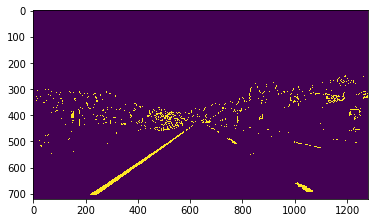

In [98]:
### Creating a binary image
### which contains likely lane pixel
### Sobel operator and color threshold ranges of HLS and HSV

def threshold_binary_image(undistorted_img):
    ### comment sobel
    gray = cv2.cvtColor(undistorted_img,cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    thresh_gray  = (180, 255)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_x = (40,120)

    hls = cv2.cvtColor(undistorted_test_img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    thresh_s = (150,255)
    
    hsv = cv2.cvtColor(undistorted_test_img, cv2.COLOR_RGB2HSV)
    V = hsv[:,:,2]
    thresh_v = (220,255)

    binary[((V > thresh_v[0])&(V <= thresh_v[1]))|((scaled_sobel > thresh_x[0]) & (scaled_sobel<=thresh_x[1]))|((S>thresh_s[0]) &(S<=thresh_s[1]))] = 1
    
    #luv = cv2.cvtColor(undistorted_test_img, cv2.COLOR_RGB2LUV)
    #L = luv[:,:,0]
    #thresh_l = [215,255]
    
    #lab = cv2.cvtColor(undistorted_test_img, cv2.COLOR_RGB2LAB)
    #B = lab[:,:,2]
    #thresh_b = [145,200]
    
    #binary[((B > thresh_b[0])&(B <= thresh_b[1]))|((L > thresh_l[0])&(L <= thresh_l[1]))|((S > thresh_s[0])&(S <= thresh_s[1]))] = 1
    
    return binary 
    
binary = threshold_binary_image(undistorted_test_img)
    
plt.figure
plt.imshow(binary)
plt.savefig('output_images/straight_lines1_binary.jpg')


In [99]:
### Perspective Transform
# Define a function that takes an undistort image to perform Perspective Transform
def warper(img_undistort, src, dst, img_size):

    # get the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img_undistort, M, img_size, flags=cv2.INTER_LINEAR)

    # Return the resulting image and matrix
    return warped, M

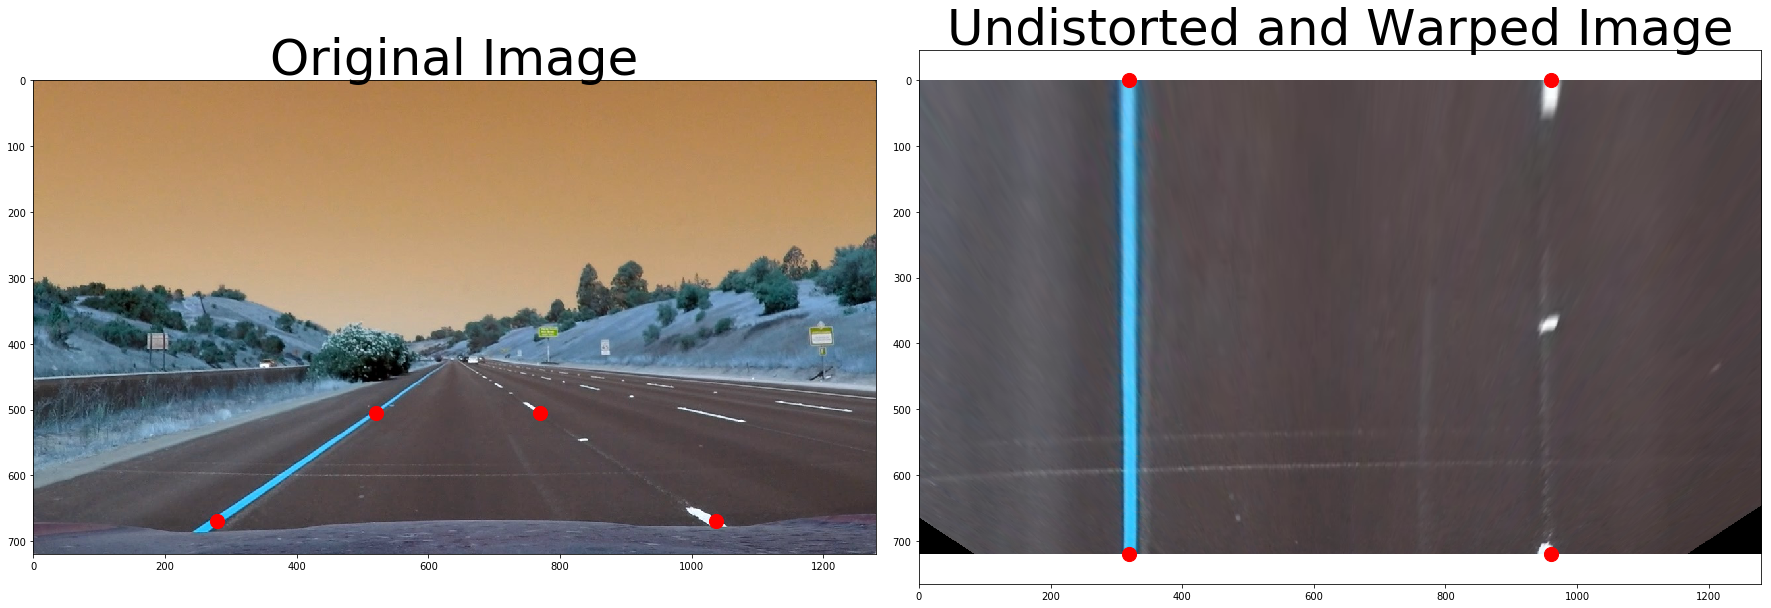

In [100]:
# Perspective transform of an undistorted image
# Grab the image shape
img_size = (undistorted_test_img.shape[1], undistorted_test_img.shape[0])


# src and dst points are in the writeup_template.md
src = np.float32(
    [[(img_size[0] / 2) - 120, img_size[1] / 2 + 145],
    [((img_size[0] / 6) + 65), img_size[1]-50],
    [(img_size[0] * 5 / 6) - 30, img_size[1]-50],
    [(img_size[0] / 2 + 130), img_size[1] / 2 + 145]])
    
dst = np.float32(
    [[(img_size[0] / 4), 0.0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0.0]])

top_down, perspective_M = warper(undistorted_test_img, src, dst, img_size)

src_x=[src[0][0],src[1][0],src[2][0],src[3][0]]
src_y=[src[0][1],src[1][1],src[2][1],src[3][1]]
dst_x=[dst[0][0],dst[1][0],dst[2][0],dst[3][0]]
dst_y=[dst[0][1],dst[1][1],dst[2][1],dst[3][1]]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test_img)
ax1.scatter(src_x,src_y, marker='o',color='red',s = 200)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.scatter(dst_x,dst_y, marker='o',color='red',s = 200)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/straight_lines1_original_undistorted_and_warped.jpg')

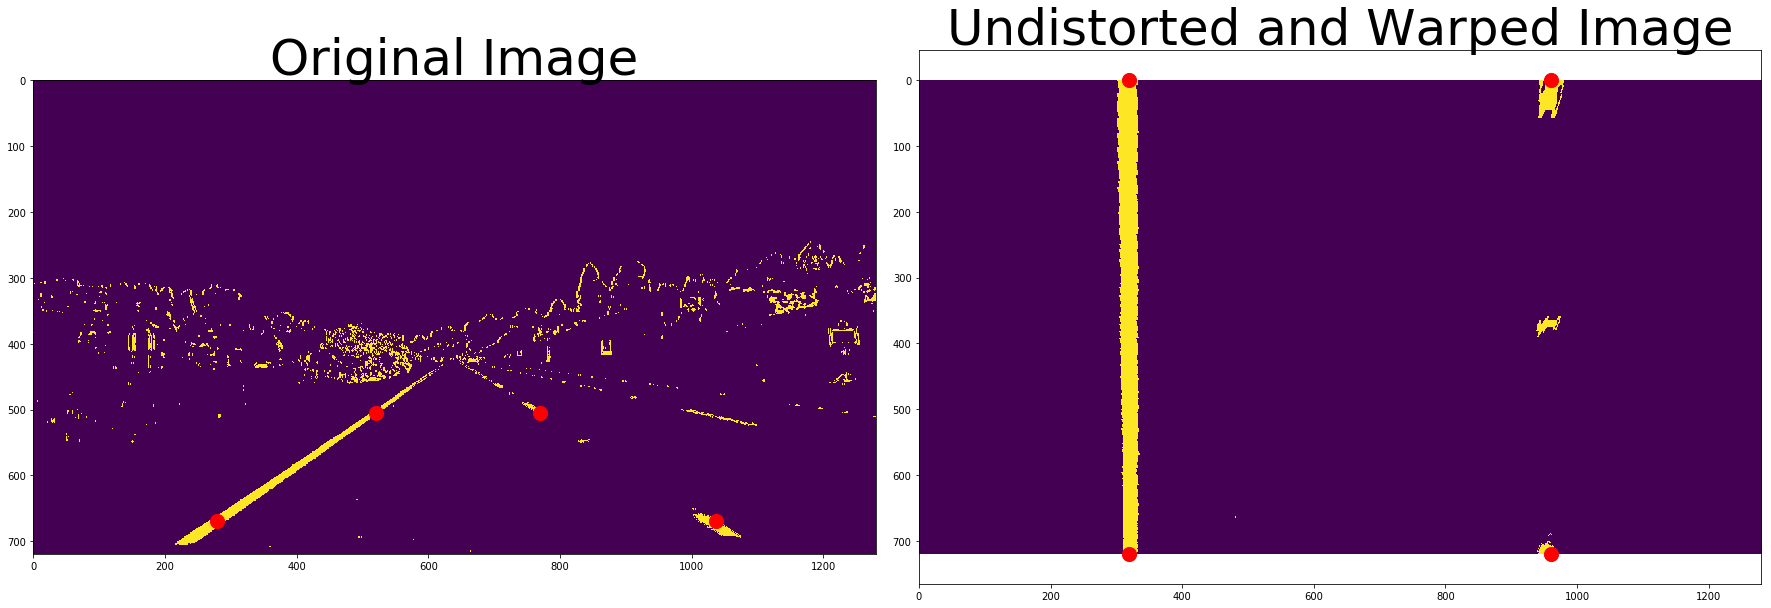

In [101]:
# Perspective Transform of an undistorted binary image
top_down_binary, perspective_M_binary = warper(binary, src, dst, img_size)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary)
ax1.scatter(src_x,src_y, marker='o',color='red',s = 200)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down_binary)
ax2.scatter(dst_x,dst_y, marker='o',color='red',s = 200)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/straight_lines1_binary_undistorted_and_warped.jpg')

In [155]:
### Identify lane line pixels
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    ### comment below when doing pipeline()
    # out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 8
    # Set the width of the windows +/- margin
    margin = 160
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        ### comment below when doing pipeline()
        
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2)
         
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #return leftx, lefty, rightx, righty, out_img
    return leftx, lefty, rightx, righty

# Find our lane pixels first
#leftx, lefty, rightx, righty, out_img = find_lane_pixels(top_down_binary)
leftx, lefty, rightx, righty = find_lane_pixels(top_down_binary)

### fit their positions with a polynomial
def fit_polynomial(image_shape, leftx, lefty, rightx, righty):
   
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, image_shape[0]-1, image_shape[0])
    
    ### comment below when doing pipeline()
    '''
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Visualization ##
   
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    plt.imshow(out_img)

    plt.savefig('output_images/straight_lines1_fit_polynomial.jpg')
    '''

    return left_fit, right_fit, ploty


left_fit, right_fit, ploty = fit_polynomial(top_down_binary.shape, leftx, lefty, rightx, righty)
#check the 'output_images/straight_lines1_fit_polynomial.jpg' for the result of this step

In [156]:
# Measure curvature in pixels
def measure_curvature_pixels(left_fit, right_fit, ploty):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]* y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad_pixels, right_curverad_pixels = measure_curvature_pixels(left_fit, right_fit, ploty)

print("curvature in pixels")
print(left_curverad_pixels, right_curverad_pixels)

curvature in pixels
288567.400758 37039.7044272


In [157]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

a_pix = xm_per_pix/(ym_per_pix**2)
b_pix = xm_per_pix/ym_per_pix

# Measure curvature in meters
def measure_curvature_meters(left_fit, right_fit, ploty, a_pix, b_pix):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*a_pix*y_eval + left_fit[1]*b_pix)**2)**1.5) / np.absolute(2*left_fit[0]*a_pix)
    right_curverad = ((1 + (2*right_fit[0]*a_pix*y_eval + right_fit[1]*b_pix)**2)**1.5) / np.absolute(2*right_fit[0]*a_pix)
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad_meters, right_curverad_meters = measure_curvature_meters(left_fit, right_fit, ploty, a_pix, b_pix)

print("curvature in meters")
print(left_curverad_meters, right_curverad_meters)

curvature in meters
94782.4006757 12224.880661


In [158]:
### measure the offset of the car with respect to the center of the lane
def measure_detection(left_fit,right_fit, y_max, xm_per_pix, center_x):
    
    left_x = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    right_x = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    
    #print(left_x)
    #print(right_x)
    
    offset = np.abs((left_x+right_x)//2-center_x)*xm_per_pix
    distance = (right_x - left_x)*xm_per_pix

    return offset, distance

    
offset, distance = measure_detection(left_fit,right_fit,test_img.shape[0],xm_per_pix,test_img.shape[1]//2)
print('the position of the vehicle with respect to center in meters (offset)')
print(offset)

print('the horizontal distance of the lanes in meters (distance)')
print(distance)

the position of the vehicle with respect to center in meters (offset)
0.0211428571429
the horizontal distance of the lanes in meters (distance)
3.33806802082


In [159]:
def drawing_detected_area(binary_warped, image, left_fit, right_fit, ploty):
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
      
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.6, 0)
    
    ### comment it when doing the pipeline
    '''
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
    # fontScale 
    fontScale = 1.5
    # Blue color in BGR 
    color = (0, 255, 0) 
    # Line thickness of 3 px 
    thickness = 3
    # Using cv2.putText() method 
    result = cv2.putText(result, 'offset [m]: '+str(offset), (200, 100), font, fontScale, color, thickness, cv2.LINE_AA)
    result = cv2.putText(result, 'radius [m]: '+str((left_curverad_meters+right_curverad_meters)*0.5), (200, 200), font, fontScale, color, thickness, cv2.LINE_AA) 
    '''
    
    return result
    
    
### comment it when doing the pipeline
#result=drawing_detected_area(top_down_binary, test_img, left_fit, right_fit, ploty)
#plt.imshow(result)
#plt.savefig('output_images/straight_lines1_lane_area_drawn.jpg')
#check the 'output_images/straight_lines1_lane_area_drawn.jpg' for the result of this step

In [160]:
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    ### uncomment below when doing pipeline()
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ### uncommnet below when doing pipeline
    return leftx, lefty, rightx, righty

    ### comment below when doing pipeline()
    '''
    # Fit new polynomials
    left_fit, right_fit, ploty = fit_polynomial(binary_warped.shape, leftx, lefty, rightx, righty)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result
    '''
    
    

### comment below when doing pipeline()

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits

#result = search_around_poly(top_down_binary, left_fit, right_fit)
#plt.imshow(result)
#plt.savefig('output_images/straight_lines1_lane_area_drawn_search_around.jpg')
#check the 'output_images/straight_lines1_lane_area_drawn_search_around.jpg' for the result of this step

In [251]:
def check_lanes_parallel (left_fit, right_fit):
    
    left_coeff = np.abs(left_fit[0]/left_fit[1])
    right_coeff = np.abs(right_fit[0]/right_fit[1])
    
    #print("coefficient")
    #print(left_coeff)
    #print(right_coeff)
    
    if left_coeff<0.01 and right_coeff<0.01:
    
        return True
    
    if left_coeff/right_coeff>1.3 or left_coeff/right_coeff<0.75:
        
        return False
    
    return True

In [252]:
def get_avg_fit_coefficient (frames_left_fit, frames_right_fit, count_frames):
    
    arr_left_fit=np.array(frames_left_fit)
    arr_right_fit=np.array(frames_right_fit)

    return np.sum(arr_left_fit,axis=0)/count_frames, np.sum(arr_right_fit,axis=0)/count_frames

In [253]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 

In [258]:
### Summarize the previous steps as a pipeline

### parameters for writing on image
font = cv2.FONT_HERSHEY_SIMPLEX 
fontScale = 1.5
color = (0, 255, 0)
thickness = 3

### an instance of class Line
line = Line()

### maximum and minimum value of horizontal distance
max_distance = 4.0
min_distance = 3.2

frames_left_fit = []
frames_right_fit = []

count_frames = 0 

def pipeline(img):
    
    global left_fit
    global right_fit
    global frames_left_fit
    global frames_right_fit
    global count_frames
    
    undistorted_img = cv2.undistort(img,mtx,dist,None,mtx)

    binary_img = threshold_binary_image(undistorted_img)
   
    warped_img, perspective_M = warper(binary_img, src, dst, img_size)
    
    if line.detected:
        
        leftx, lefty, rightx, righty = search_around_poly(warped_img, left_fit, right_fit)
        
        left_fit, right_fit, ploty = fit_polynomial(warped_img.shape, leftx, lefty, rightx, righty)
        
        left_curverad_meters, right_curverad_meters = measure_curvature_meters(left_fit, right_fit, ploty, a_pix, b_pix)
        
        radius_of_curvature = (left_curverad_meters+right_curverad_meters)*0.5
        
        offset, distance = measure_detection(left_fit,right_fit,warped_img.shape[0],xm_per_pix,warped_img.shape[1]//2)
           
        #print(distance)
            
        if distance < min_distance or distance > max_distance and not check_lanes_parallel (left_fit, right_fit): 
        
            line.detected = False
            
        else: 
            
            frames_left_fit.append(left_fit)
            
            frames_right_fit.append(right_fit)
            
            count_frames = count_frames+1
                      
            
    if not line.detected:
        
        leftx, lefty, rightx, righty = find_lane_pixels(warped_img)
        
        left_fit, right_fit, ploty = fit_polynomial(warped_img.shape, leftx, lefty, rightx, righty)
        
        left_curverad_meters, right_curverad_meters = measure_curvature_meters(left_fit, right_fit, ploty, a_pix, b_pix)
        
        radius_of_curvature = (left_curverad_meters+right_curverad_meters)*0.5
        
        offset, distance = measure_detection(left_fit,right_fit,warped_img.shape[0],xm_per_pix,warped_img.shape[1]//2)
        
        line.detected = True
        
        frames_left_fit.append(left_fit)
        
        frames_right_fit.append(right_fit)
        
        count_frames = count_frames+1
        
    if count_frames == 10:
        
        line.radius_of_curvature = radius_of_curvature
    
        line.line_base_pos = offset
        
        avg_left_fit,avg_right_fit = get_avg_fit_coefficient (frames_left_fit, frames_right_fit, count_frames)
         
        result = drawing_detected_area(warped_img, undistorted_img, avg_left_fit, avg_right_fit, ploty)
    
        result = cv2.putText(result, 'offset [m]: '+str(line.line_base_pos), (200, 100), font, fontScale, color, thickness, cv2.LINE_AA)
        result = cv2.putText(result, 'radius [m]: '+str(line.radius_of_curvature), (200, 200), font, fontScale, color, thickness, cv2.LINE_AA) 
    
        #result = cv2.putText(result, 'left_coeff: '+str(left_fit[0]/left_fit[1]), (200, 300), font, fontScale, color, thickness, cv2.LINE_AA) 
        #result = cv2.putText(result, 'right_coeff: '+str(right_fit[0]/right_fit[1]), (200, 400), font, fontScale, color, thickness, cv2.LINE_AA) 
    
        count_frames = count_frames - 1
        
        frames_left_fit.pop(0)
        
        frames_right_fit.pop(0)
        
        return result
    
    line.radius_of_curvature = radius_of_curvature
    
    line.line_base_pos = offset
         
    result = drawing_detected_area(warped_img, undistorted_img, left_fit, right_fit, ploty)
                                   
    result = cv2.putText(result, 'offset [m]: '+str(line.line_base_pos), (200, 100), font, fontScale, color, thickness, cv2.LINE_AA)
    result = cv2.putText(result, 'radius [m]: '+str(line.radius_of_curvature), (200, 200), font, fontScale, color, thickness, cv2.LINE_AA) 
    
    return result

In [259]:
### Video Processing Section
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

video_output = './output_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("./project_video.mp4").subclip(0,2)
clip1 = VideoFileClip("./project_video.mp4")
video_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video ./output_project_video.mp4
[MoviePy] Writing video ./output_project_video.mp4



 24%|██▍       | 303/1261 [00:54<03:22,  4.73it/s]


 48%|████▊     | 605/1261 [01:52<02:14,  4.86it/s]


 72%|███████▏  | 907/1261 [02:51<01:05,  5.45it/s]


 96%|█████████▌| 1205/1261 [03:50<00:10,  5.13it/s]


100%|█████████▉| 1260/1261 [04:01<00:00,  5.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_project_video.mp4 

CPU times: user 1min 56s, sys: 2.75 s, total: 1min 59s
Wall time: 4min 4s


In [266]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [263]:
challenge_video_output = './output_challenge_video.mp4'
clip2 = VideoFileClip("./challenge_video.mp4")
challenge_video_clip = clip2.fl_image(pipeline) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video ./output_challenge_video.mp4
[MoviePy] Writing video ./output_challenge_video.mp4



 32%|███▏      | 155/485 [00:27<01:08,  4.81it/s]


 64%|██████▎   | 309/485 [00:57<00:33,  5.29it/s]


 95%|█████████▌| 463/485 [01:26<00:04,  5.15it/s]


100%|██████████| 485/485 [01:31<00:00,  5.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_challenge_video.mp4 

CPU times: user 45.1 s, sys: 2.46 s, total: 47.5 s
Wall time: 1min 34s


In [267]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))

In [268]:
harder_challenge_video_output = './output_harder_challenge_video.mp4'
clip3 = VideoFileClip("./harder_challenge_video.mp4")
harder_challenge_video_clip = clip3.fl_image(pipeline) #NOTE: this function expects color images!!
%time harder_challenge_video_clip.write_videofile(harder_challenge_video_output, audio=False)

[MoviePy] >>>> Building video ./output_harder_challenge_video.mp4
[MoviePy] Writing video ./output_harder_challenge_video.mp4



 13%|█▎        | 152/1200 [00:31<04:13,  4.14it/s]


 25%|██▌       | 303/1200 [01:07<03:34,  4.17it/s]


 38%|███▊      | 454/1200 [01:45<03:04,  4.04it/s]


 50%|█████     | 605/1200 [02:19<02:08,  4.64it/s]


 63%|██████▎   | 756/1200 [02:56<01:59,  3.72it/s]


 76%|███████▌  | 907/1200 [03:35<01:08,  4.29it/s]


 88%|████████▊ | 1057/1200 [04:10<00:33,  4.22it/s]


100%|█████████▉| 1199/1200 [04:44<00:00,  4.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_harder_challenge_video.mp4 

CPU times: user 1min 58s, sys: 10.1 s, total: 2min 8s
Wall time: 4min 48s


In [269]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video_output))